In [64]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [65]:
save_path = "/Users/iandavenport/Desktop/research/projects/stability/vids/python_vids/g66_t3_c8/"
ims_path = save_path + "full_processed/extracted_data/"

In [66]:
files = []
for filename in os.listdir(ims_path):
    if filename.endswith(".npz"):
        im_file = os.path.join(ims_path, filename)
        files.append(im_file)

In [67]:
def extract_num_from_npy_string(string):
    numbers = re.findall("[0-9]+", string[-9:])
    numbers = int(numbers[0])
    return numbers

In [68]:
fnames = sorted(files, key=extract_num_from_npy_string)

In [69]:
# format is cropped image, interpolated line, interpolation points, curvature, and crop points!
cropped_images = []
interpolated_lines = []
interpolation_points = []
curvatures = []
# crop_points = []

# populate the arrays
for f in fnames:
    arr = np.load(f)
    cropped_images.append(arr["arr_0"])
    interpolated_lines.append(arr["arr_1"])
    interpolation_points.append(arr["arr_2"])
    curvatures.append(arr["arr_3"])
    # crop_points.append(arr["arr_4"])

## clip and filter

In [70]:
from scipy.signal import savgol_filter

# curvatures = [
#     np.clip(curvature_arr, a_min=0, a_max=.3) for curvature_arr in curvatures
# ]
# curvatures = [savgol_filter(c, 5, 2) for c in curvatures]

## First create the tuples

In [71]:
n_ims = len(interpolation_points)
frms_list = []
for i in range(n_ims):
    frmi = list(zip(interpolation_points[i], curvatures[i]))
    frms_list.append(frmi)

In [72]:
def deal_with_zero_dup(tup_list: list, arr_idx: int, n_ims: int) -> list:
    """
    Drop the tuples which duplicate zero starting elements

    Just gets rid of duplicates in the list and makes interpolation easier.
    In general this is a dirty method but it's better than nothing.
    """
    zero_start_list = [i for i in tup_list if i[0] == 0.0]
    tup_list = tup_list[n_ims:]  # ignore the first n_ims things
    tup = zero_start_list[arr_idx]
    tup_list.insert(0, tup)
    return tup_list

## Now I need to go through and append the curvatures that are not the same

This code is not clear but this is where magic is happening. This is what is allowing me to plot the curvature at each frame in the image. I need to step through this line by line.

In [73]:
zeros_list = np.zeros(100)
padded_frames = []
for i in range(n_ims):
    frmi = frms_list[i]
    idxs = list(np.linspace(0, n_ims - 1, n_ims, dtype=int))
    idxs.remove(i)
    for idx in idxs:
        zipped = list(zip(interpolation_points[idx], zeros_list))
        frmi.extend(zipped)
    frmi.sort(key=lambda el: el[0])
    frmi = deal_with_zero_dup(frmi, i, n_ims)
    padded_frames.append(frmi)

In [74]:
ext_curvatures = []
for lst in padded_frames:
    ext_curve = [tup[1] for tup in lst]
    ext_curvatures.append(ext_curve)

In [75]:
curve_mat = np.vstack(ext_curvatures)

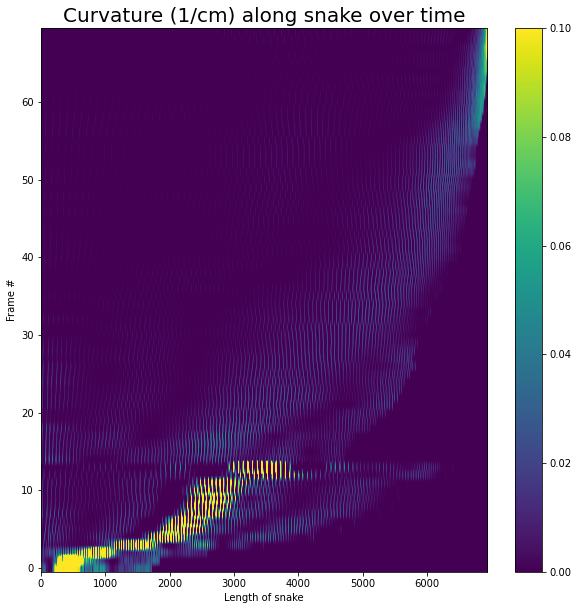

In [78]:
plt.figure(figsize=(10, 10))
plt.imshow(
    curve_mat[::], interpolation=None, cmap="viridis", aspect="auto", origin="lower"
)
plt.clim(vmin=0, vmax=0.1)
plt.colorbar()
plt.xlabel("Length of snake")
plt.ylabel("Frame #")
plt.title("Curvature (1/cm) along snake over time", fontsize=20)
# plt.show()
plt.savefig(save_path + "/time_kymograph.png")

## Now I need to figure out some kind of interpolation scheme to get rid of the stripes where I don't really want them